In [103]:
# imports
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

#### Loading the images from the data folder 

In [104]:
def load_dataset_with_names(folder_path):
    dataset = []

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        if file_path.endswith(('.png')):
            img = Image.open(file_path)
            img_array = np.array(img)
            parts = filename.split('.')
            subject = parts[0]
            emotion = parts[1]

            img_info = {'image': img_array, 'subject': subject, 'emotion': emotion}

            dataset.append(img_info)

    return dataset


In [105]:
folder_path = 'data/'
image_dataset_raw = load_dataset_with_names(folder_path)

In [106]:
image_dataset_raw[0]

{'image': array([[130, 130, 130, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [ 68,  68,  68, ...,  68,  68,  68]], dtype=uint8),
 'subject': 'subject01',
 'emotion': 'centerlight'}

In [107]:
print(f"Number of images: {len(image_dataset_raw)}")
print(f"shape of Images: {image_dataset_raw[0]['image'].shape}")

Number of images: 165
shape of Images: (243, 320)


#### Preparing the training & testing dataset


* All persons images are being used for the training (8 of 11 pose images for train and 3 of 11 for test)

In [108]:
train_data = {}
test_data = {}
for i in image_dataset_raw:
    train_data[i['subject']] = [img['image'] for img in image_dataset_raw if (img['subject'] == i['subject'] and img['emotion'] not in ['happy', 'sad', 'surprised'])]

    test_data[i['subject']] = [img['image'] for img in image_dataset_raw if (img['subject'] == i['subject'] and img['emotion'] in ['happy', 'sad', 'surprised'])]

In [109]:
train_data.keys()

dict_keys(['subject01', 'subject02', 'subject03', 'subject04', 'subject05', 'subject06', 'subject07', 'subject08', 'subject09', 'subject10', 'subject11', 'subject12', 'subject13', 'subject14', 'subject15'])

In [110]:
print(len(train_data['subject01']))
print(len(test_data['subject01']))

8
3


#### Scaling the pixel values

In [111]:
# scaling the images
train_data = {k: [img/255 for img in v] for k, v in train_data.items()}
test_data = {k: [img/255 for img in v] for k, v in test_data.items()}

In [112]:
train_data['subject01'][0].shape

(243, 320)

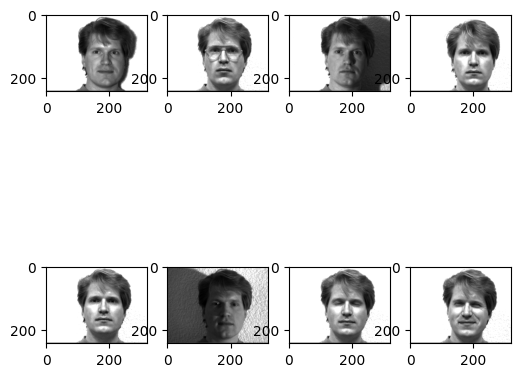

In [113]:
num_images = len(train_data['subject01'])
num_rows = 2
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(train_data['subject01'][i], cmap='gray')
plt.show()

#### Flattening the train_data & test_data

In [114]:
# flatten the images
train_data = {k: [img.flatten() for img in v] for k, v in train_data.items()}
test_data = {k: [img.flatten() for img in v] for k, v in test_data.items()}

In [115]:
print(train_data['subject01'][0].shape)
print(test_data['subject01'][0].shape)

(77760,)
(77760,)


#### PCA
* We must perform dimensionality reduction to compute the scatter matrices and others

In [161]:
# reducing the dimensionality of the images using PCA
mean_face_overall = np.mean([img for subject in train_data.values() for img in subject], axis=0)
centered_train_data = {k: [img - mean_face_overall for img in v] for k, v in train_data.items()}
cov_overall = np.cov(np.array([img for subject in centered_train_data.values() for img in subject]))
cov_overall.shape

(120, 120)

In [166]:
eigenvalues_overall, eigenvectors_overall = np.linalg.eig(cov_overall)
eigenvectors_overall.shape

(120, 120)

In [191]:
sorted_eigenvectors_overall = eigenvectors_overall[:, np.argsort(eigenvalues_overall)[::-1]]
selected_eigenvectors_overall = sorted_eigenvectors_overall[:, :100]
selected_eigenvectors_overall.shape

(120, 100)

In [192]:
all_data = np.array([img for subject in centered_train_data.values() for img in subject])
all_data.shape

(120, 77760)

In [193]:
reduced_all_data = np.dot(selected_eigenvectors_overall.T, all_data)
reduced_all_data.shape
projected_train_data = np.dot(all_data, reduced_all_data.T)

In [194]:
projected_train_data.shape

(120, 100)

In [195]:
new_train_data = {k: [img for img in projected_train_data[i:i+8]] for i, (k, v) in enumerate(train_data.items())}

In [198]:
len(new_train_data['subject01'])

8

In [199]:
new_train_data['subject01'][0].shape

(100,)

#### Calculating the overall_mean & class_mean

In [245]:
overall_mean = np.mean([img for subject in new_train_data.values() for img in subject], axis=0)
class_mean = {k: np.mean(v, axis=0) for k, v in new_train_data.items()}

In [246]:
print(len(class_mean))
print(overall_mean.shape)

15
(100,)


#### Substracting the class_mean from the train images

In [247]:
train_data_centered = {k: [img - class_mean[k] for img in v] for k, v in new_train_data.items()}

#### Within class scatter matrix

In [248]:
# per class scatter matrix
s1 = sum(np.outer(train_data_centered['subject01'][i], train_data_centered['subject01'][i]) for i in range(8))
s2 = sum(np.outer(train_data_centered['subject02'][i], train_data_centered['subject02'][i]) for i in range(8))
s3 = sum(np.outer(train_data_centered['subject03'][i], train_data_centered['subject03'][i]) for i in range(8))
s4 = sum(np.outer(train_data_centered['subject04'][i], train_data_centered['subject04'][i]) for i in range(8))
s5 = sum(np.outer(train_data_centered['subject05'][i], train_data_centered['subject05'][i]) for i in range(8))
s6 = sum(np.outer(train_data_centered['subject06'][i], train_data_centered['subject06'][i]) for i in range(8))
s7 = sum(np.outer(train_data_centered['subject07'][i], train_data_centered['subject07'][i]) for i in range(8))
s8 = sum(np.outer(train_data_centered['subject08'][i], train_data_centered['subject08'][i]) for i in range(8))
s9 = sum(np.outer(train_data_centered['subject09'][i], train_data_centered['subject09'][i]) for i in range(8))
s10 = sum(np.outer(train_data_centered['subject10'][i], train_data_centered['subject10'][i]) for i in range(8))
s11 = sum(np.outer(train_data_centered['subject11'][i], train_data_centered['subject11'][i]) for i in range(8))
s12 = sum(np.outer(train_data_centered['subject12'][i], train_data_centered['subject12'][i]) for i in range(8))
s13 = sum(np.outer(train_data_centered['subject13'][i], train_data_centered['subject13'][i]) for i in range(8))
s14 = sum(np.outer(train_data_centered['subject14'][i], train_data_centered['subject14'][i]) for i in range(8))
s15 = sum(np.outer(train_data_centered['subject15'][i], train_data_centered['subject15'][i]) for i in range(8))

s_w = s1 + s2 + s3 + s4 + s5 + s6 + s7 + s8 + s9 + s10 + s11 + s12 + s13 + s14 + s15


In [249]:
s_w.shape

(100, 100)

#### Between class scatter matrix

In [254]:
# between class scatter matrix
s_b = sum(8 * np.outer((class_mean[k]-overall_mean), (class_mean[k]-overall_mean).T) for k in train_data_centered.keys())


In [256]:
s_b.shape

(100, 100)

In [262]:
s_w_inv = np.linalg.inv(s_w)
ei_values, ei_vectors = np.linalg.eig(np.dot(s_w_inv, s_b))

In [266]:
print(ei_vectors.shape)
print(ei_values.shape)

(100, 100)
(100,)


In [276]:
sorted_eigenvectors = ei_vectors[:, np.argsort(ei_values)[::-1]]
selected_eigenvectors = sorted_eigenvectors[:, :50]
selected_eigenvectors.shape

(100, 50)

#### Projecting on the selected eigen vectors

In [284]:
all_data = np.array([img for subject in train_data_centered.values() for img in subject])
all_data_projected = np.dot(all_data, selected_eigenvectors)
train_data_projected = {k: [img for img in all_data_projected[i:i+8]] for i, (k, v) in enumerate(train_data_centered.items())}

In [285]:
train_data_projected['subject01'][0].shape

(50,)

In [122]:
# num_images = len(train_data_centered['subject01'])
# num_rows = 2
# num_cols = 4
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, 6))
# for i, ax in enumerate(axes.flat):
#     if i < num_images:
#         ax.imshow(train_data_centered['subject01'][i].reshape((243, 320)), cmap='gray')
# plt.show()